In [1]:
from BorutaShap import BorutaShap, load_data

In [2]:
import pandas as pd, numpy as np, scipy, os, itertools
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from func import loaders
forest = RandomForestRegressor(max_depth = 10, n_jobs=-1)

In [3]:
outcome_df = pd.read_csv('./data/clinical data/clinical_data_2.csv')[['subj', 'AD8主觀認知障礙[0-1,>=2]', 'MOCA客觀認知測驗分數[<=23,>=24]']]
data_type ='mean' #mean, var
ld_excel = loaders(data_type = data_type)
ld_mat = loaders(data_type=data_type)
raw_data_path = './data/dFC matrix matlab/'
for next_path in sorted(os.listdir(raw_data_path)):
    if 'C0018FC_z.mat' not in next_path:
        ld_mat.load_mat(data_path = os.path.join(raw_data_path,next_path))
alff_index, alff_value, alff_columns = ld_excel.load_csv(data_path=f'./data/mdALFF matrix excel/mdALFF_{data_type}.csv')
fc_value = ld_mat.callback()

In [4]:
fc_value.shape, alff_value.shape

((84, 44850), (84, 300))

In [5]:
from import_library import *

def data_spilt(patient_value, label_, outcome_name = 'AD8主觀認知障礙[0-1,>=2'):
    if 'MOCA' in outcome_name:
        label_s = [1 if (i>=24)  else 0  for i in list(label_)]
    elif 'AD8' in outcome_name:
        label_s = [1 if i>=2 else 0 for i in list(label_)]
        label_ = label_+1
    X_train, X_test, Y_label, _  = train_test_split(patient_value, list(label_s) , stratify=list(label_s), random_state=123)
    y_train, y_test, _, _ = train_test_split(list(label_), list(label_s) , stratify=list(label_s), random_state=123)
    return X_train, y_train, X_test, y_test
    # 1.feature selection for total dataset or train dataset
    # 2.feature selection overfitting?[boruta]. depth?
    # 3._add_shadows_get_imps
    
def rank_csv():
    pass
model_stack_ALFF = {'BorutaPy':[], 'BorutaShap':[]}
model_stack_FC = {'BorutaPy':[], 'BorutaShap':[]}
for idx, outcome_name in enumerate(['AD8主觀認知障礙[0-1,>=2]', 'MOCA客觀認知測驗分數[<=23,>=24]']):
    # FC feature selection
    print(f"FC {data_type} Feature Selection:", outcome_name)
    X, y, _, _ = data_spilt(fc_value, outcome_df[outcome_name], outcome_name,)
    feat_selector_fc = BorutaPy(forest, n_estimators='auto',verbose=0, random_state=123)
    feat_selector_fc.fit(np.array(X), np.array(y))
    model_stack_FC['BorutaPy'].append(feat_selector_fc)
    # feature_df = pd.DataFrame([f'FC_{data_type}_{i}' for i in range (fc_value.shape[1])], columns=['features'])
    # feature_df['rank'] = feat_selector_fc.ranking_
    # feature_df = feature_df.sort_values(by=['rank']).reset_index()
    # feature_df.to_csv(f'./feature_selection/{outcome_name}_FC_{data_type}_feature-selection.csv')
    Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)
    Feature_Selector.fit(X=pd.DataFrame(X, columns=[f'FC_{data_type}_{i}' for i in range (fc_value.shape[1])]), y=np.array(y), n_trials=200, sample=False,train_or_test = 'test', normalize=False, verbose=False)
    model_stack_FC['BorutaShap'].append(Feature_Selector)


    # ALFF feature selection
    print(f"ALFF {data_type} Feature Selection:", outcome_name)
    X, y, _, _  = data_spilt(alff_value, outcome_df[outcome_name], outcome_name = outcome_name)
    feat_selector_alff = BorutaPy(forest, n_estimators='auto',verbose=0, random_state=123)
    feat_selector_alff.fit(np.array(X), np.array(y))
    model_stack_ALFF['BorutaPy'].append(feat_selector_alff)
    # feature_df = pd.DataFrame(alff_columns.tolist(), columns=['features'])
    # feature_df['rank'] = feat_selector_alff.ranking_
    # feature_df = feature_df.sort_values(by=['rank']).reset_index()
    # feature_df.to_csv(f'./feature_selection/{outcome_name}_ALFF_{data_type}_feature-selection.csv')
    Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)
    Feature_Selector.fit(X=X, y=np.array(y), n_trials=200, sample=False,train_or_test = 'test', normalize=False, verbose=False)
    model_stack_ALFF['BorutaShap'].append(Feature_Selector)
    


FC mean Feature Selection: AD8主觀認知障礙[0-1,>=2]


  0%|          | 0/200 [00:00<?, ?it/s]

ALFF mean Feature Selection: AD8主觀認知障礙[0-1,>=2]


  0%|          | 0/200 [00:00<?, ?it/s]

FC mean Feature Selection: MOCA客觀認知測驗分數[<=23,>=24]


  0%|          | 0/200 [00:00<?, ?it/s]

ALFF mean Feature Selection: MOCA客觀認知測驗分數[<=23,>=24]


  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
for model_, d_t in zip(model_stack_FC['BorutaPy'],[f'FC {data_type} - AD8', f'FC {data_type} - MOCA']):
    print('-----BorutaShap ',d_t,'-----')
    X, y, _, _ = data_spilt(fc_value, outcome_df[outcome_name], outcome_name,)
    X = pd.DataFrame(X, columns=[f'FC_{data_type}_{i}' for i in range (fc_value.shape[1])])
    green_area = X.columns[model_.support_].to_list()
    blue_area  = X.columns[model_.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

-----BorutaShap  FC mean - AD8 -----
features in the green area: ['FC_mean_1378', 'FC_mean_23144', 'FC_mean_37664']
features in the blue area: []
-----BorutaShap  FC mean - MOCA -----
features in the green area: ['FC_mean_7773', 'FC_mean_7865', 'FC_mean_25144', 'FC_mean_38646']
features in the blue area: []


In [7]:
for model_, d_t in zip(model_stack_ALFF['BorutaPy'],[f'ALFF {data_type} - AD8', f'ALFF {data_type} - MOCA']):
    print('-----BorutaShap ',d_t,'-----')
    X, y, _, _  = data_spilt(alff_value, outcome_df[outcome_name], outcome_name = outcome_name)
    green_area = X.columns[model_.support_].to_list()
    blue_area  = X.columns[model_.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)

-----BorutaShap  ALFF mean - AD8 -----
features in the green area: ['288_FrontoParietal']
features in the blue area: ['277_DefaultMode']
-----BorutaShap  ALFF mean - MOCA -----
features in the green area: ['255_SomatomotorLateral']
features in the blue area: []


-----BorutaShap  FC mean - AD8 -----
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


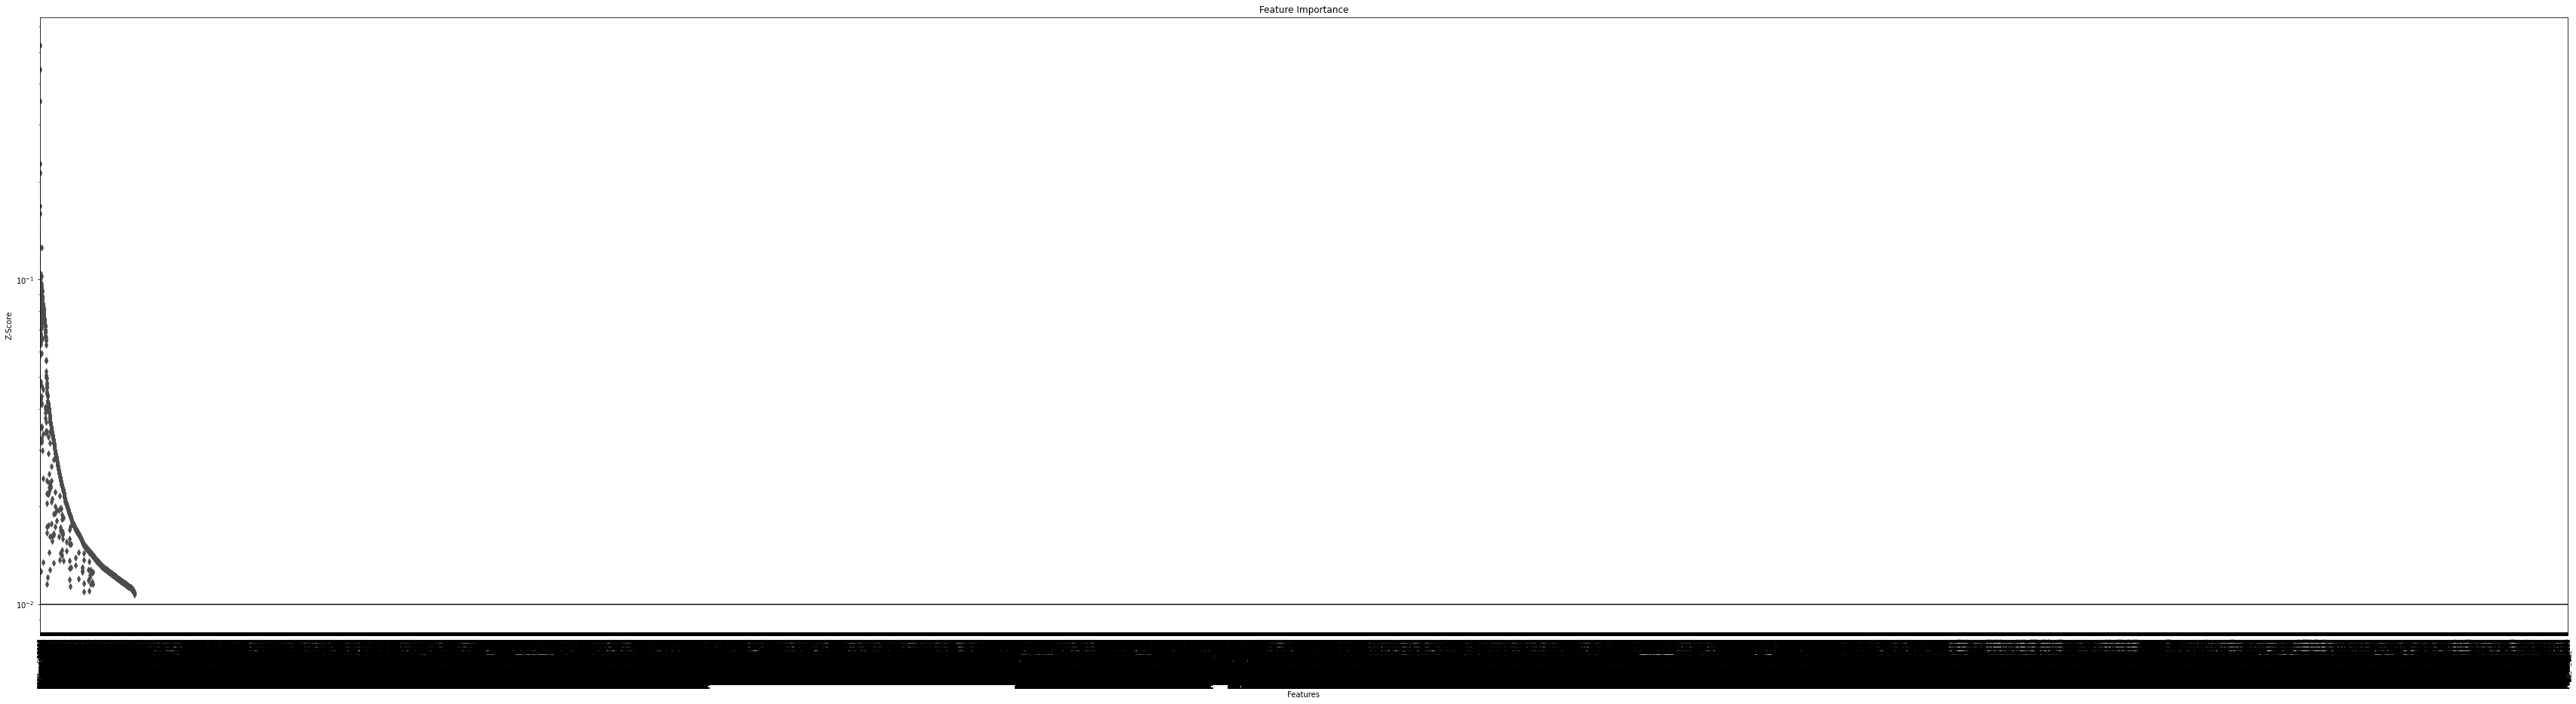

-----BorutaShap  FC mean - MOCA -----
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


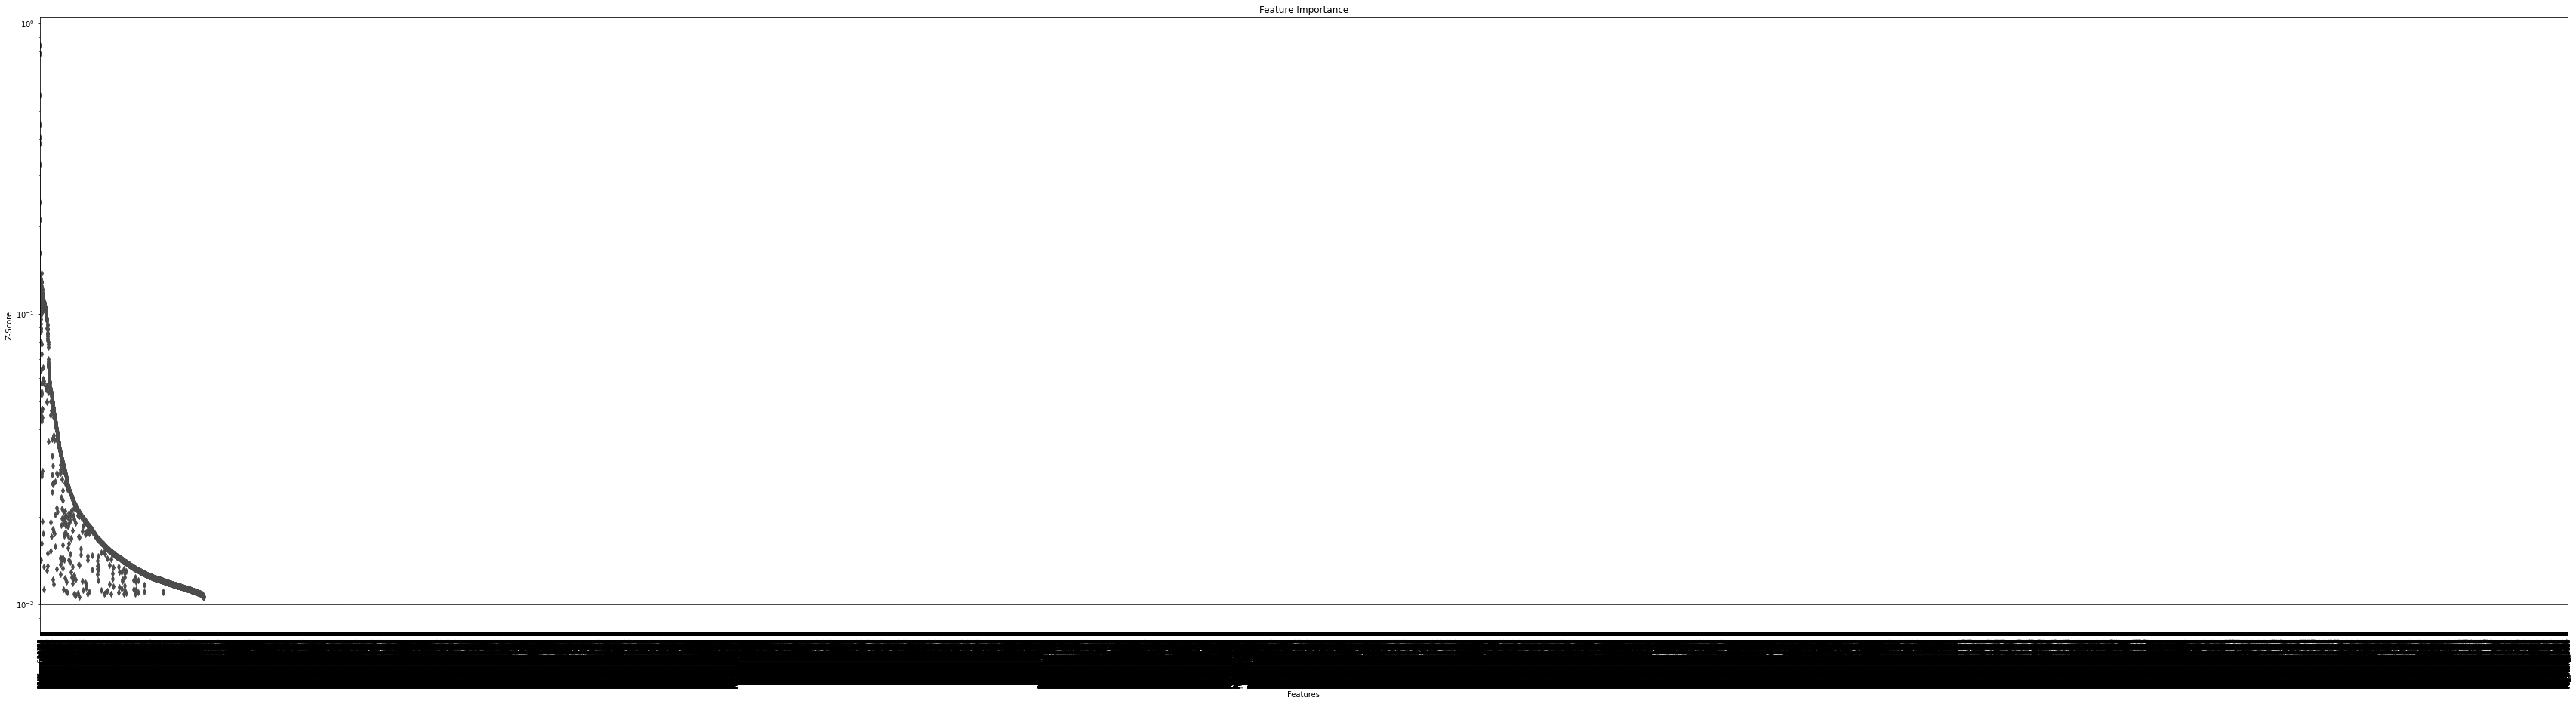

In [8]:
for model_, d_t in zip(model_stack_FC['BorutaShap'],[f'FC {data_type} - AD8', f'FC {data_type} - MOCA']):
    X, y, _, _ = data_spilt(fc_value, outcome_df[outcome_name], outcome_name,)
    X = pd.DataFrame(X, columns=[f'FC_{data_type}_{i}' for i in range (fc_value.shape[1])])
    subset = model_.Subset()
    print('-----BorutaShap ',d_t,'-----')
    print(subset.head())
    model_.plot(which_features='all', figsize=(60,15))

In [55]:
models_ = model_stack_ALFF['BorutaShap'][1]

In [56]:
models_.X_shadow

,shadow_25_SomatomotorDorsal,shadow_255_SomatomotorLateral
2,0.708732,1.019147
23,0.786325,0.902146
15,1.234316,0.784702
24,0.995912,0.847463
72,0.906825,0.940864
...,...,...
44,1.315251,0.933409
37,0.611780,0.809169
13,0.525719,1.000523
61,1.155188,1.027255


-----BorutaShap  ALFF mean - AD8 -----
Empty DataFrame
Columns: []
Index: [47, 78, 53, 66, 61]


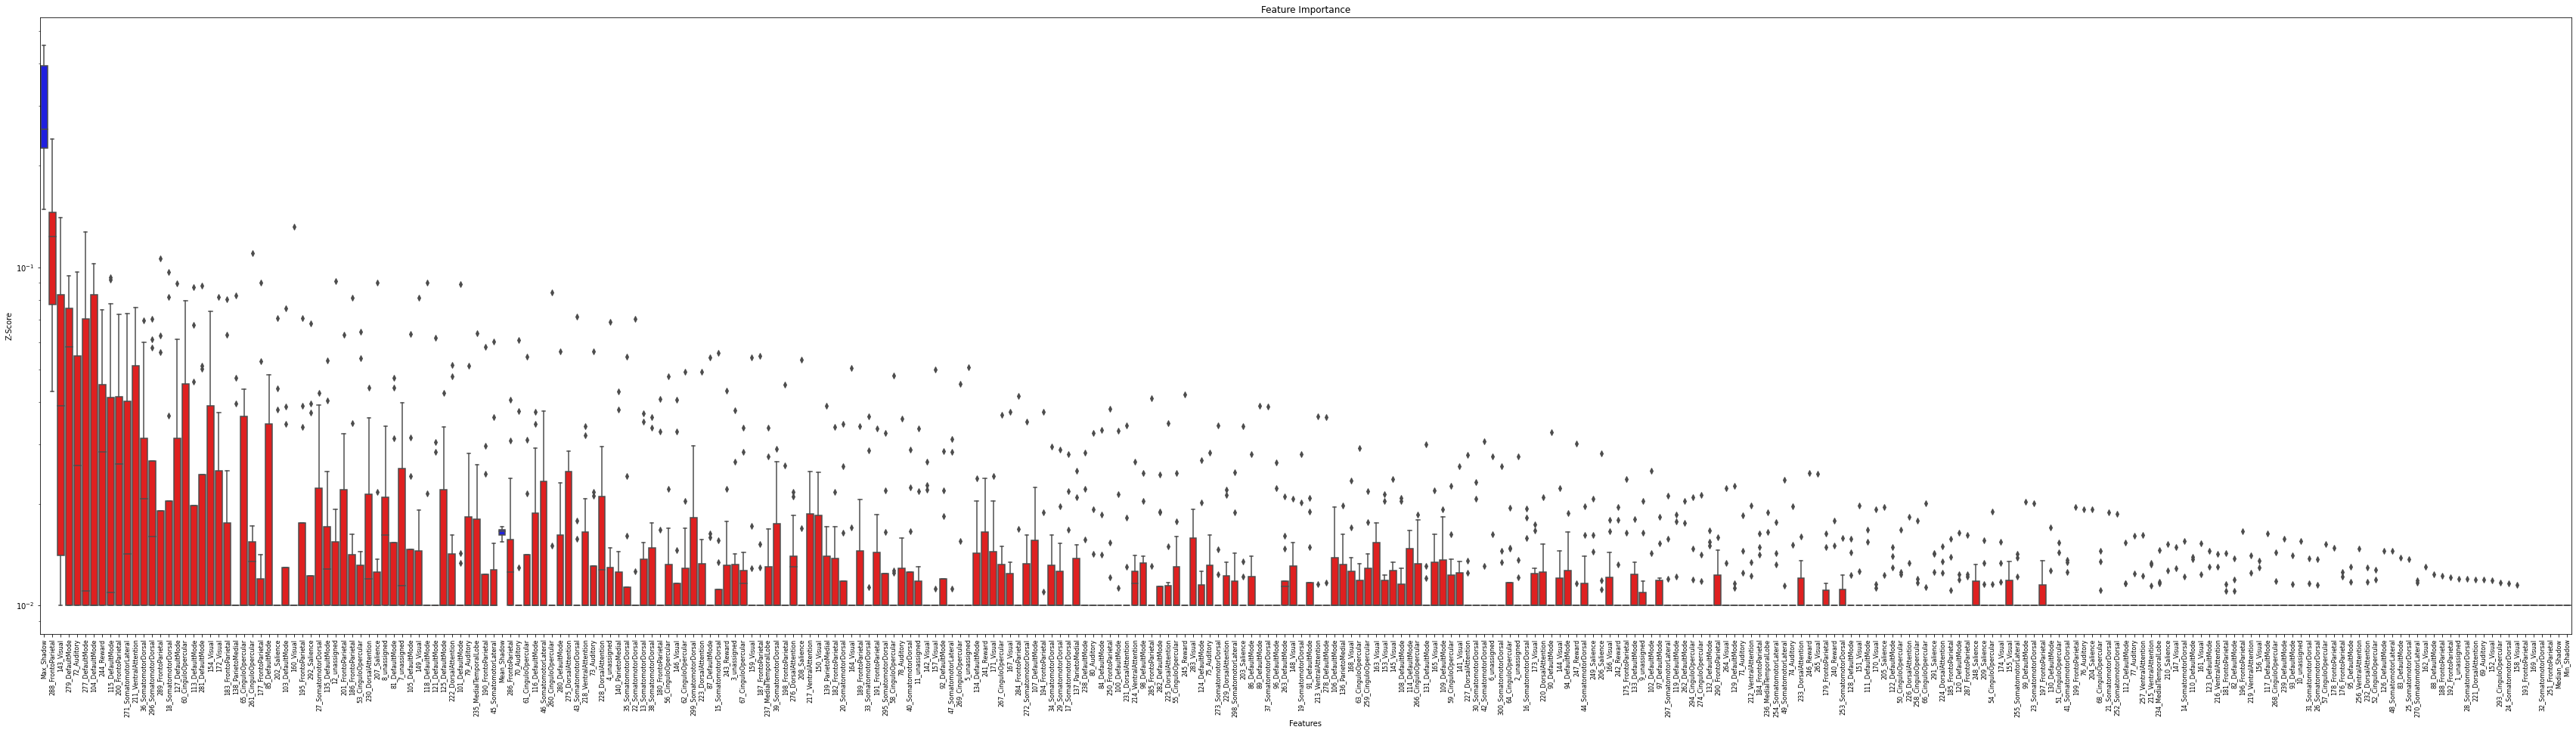

-----BorutaShap  ALFF mean - MOCA -----
    255_SomatomotorLateral  25_SomatomotorDorsal
2                 0.808582              1.123217
23                0.720667              1.060910
15                0.933409              1.080135
24                0.806721              1.370852
72                0.839249              1.079559


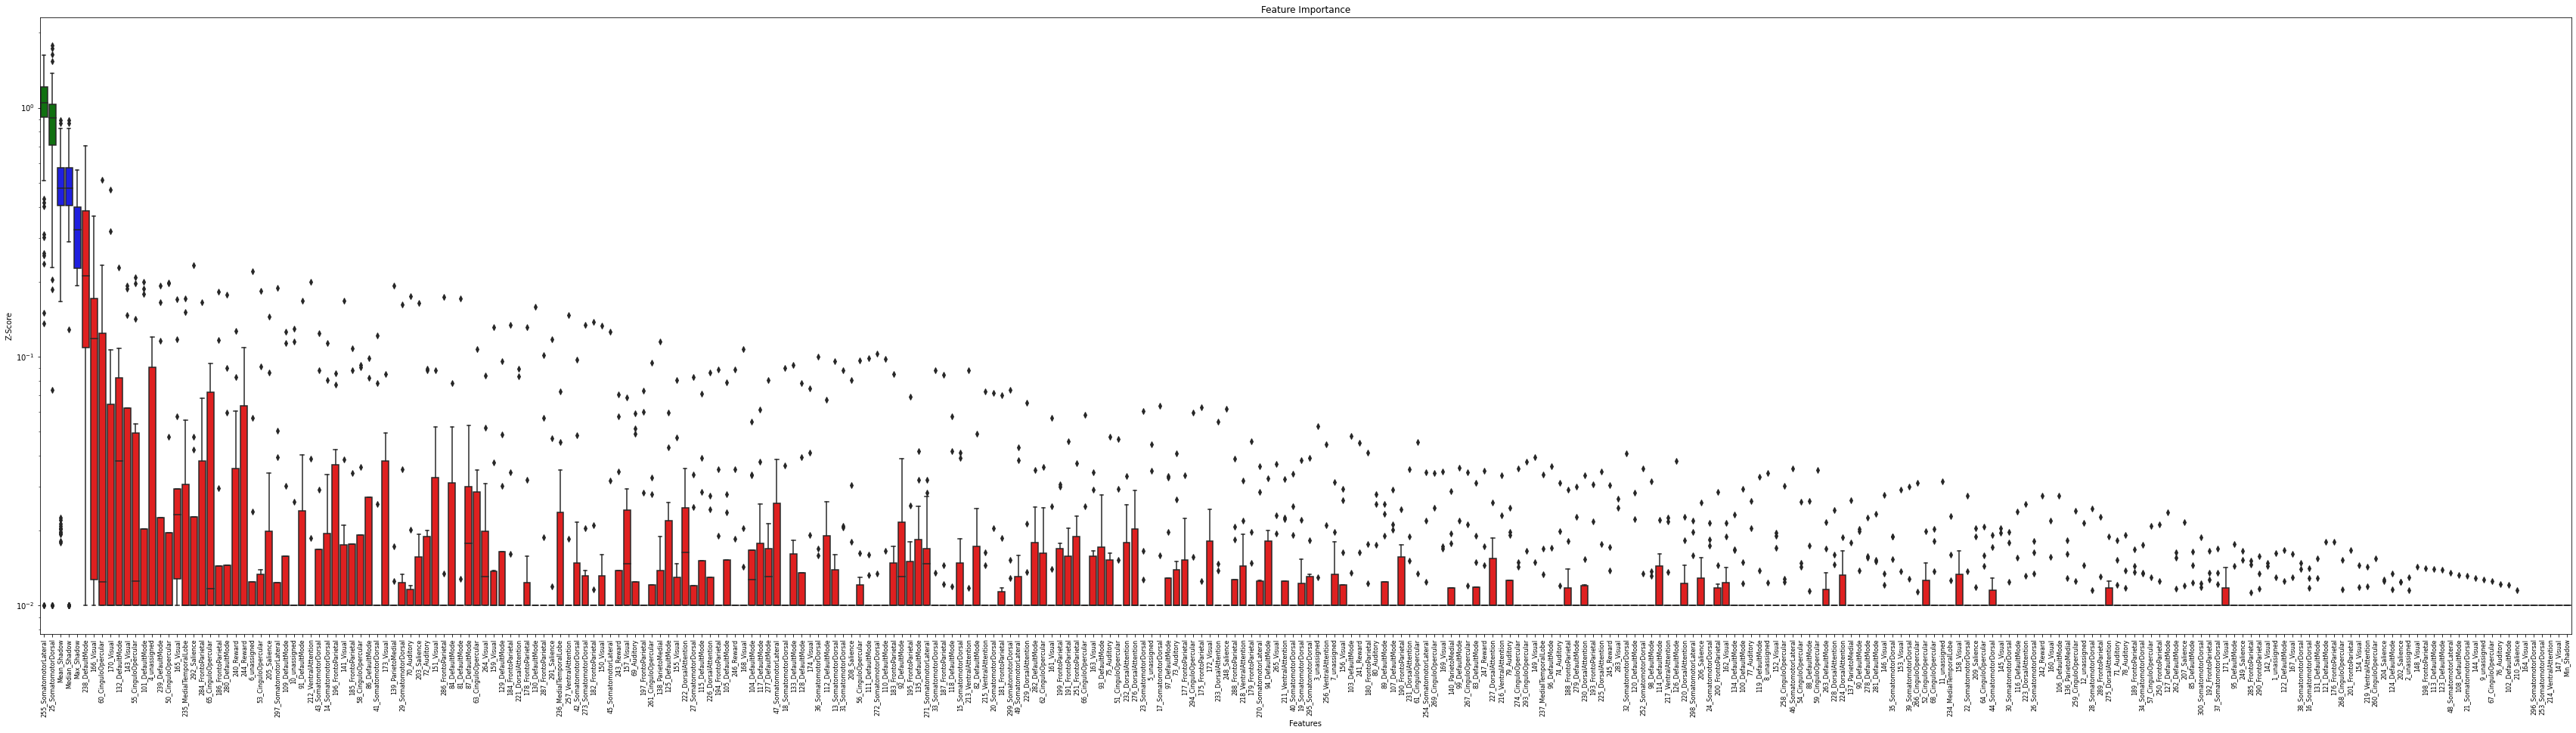

In [9]:
for model_, d_t in zip(model_stack_ALFF['BorutaShap'],[f'ALFF {data_type} - AD8', f'ALFF {data_type} - MOCA']):
    X, y, _, _  = data_spilt(alff_value, outcome_df[outcome_name], outcome_name = outcome_name)
    subset = model_.Subset()
    print('-----BorutaShap ',d_t,'-----')
    print(subset.head())
    model_.plot(which_features='all', figsize=(60,15))

In [10]:
# Feature_Selector.plot(which_features='all', figsize=(60,15))

In [11]:
# feat_selector_alff.transform(np.array(X))

In [12]:
# green_area = X.columns[feat_selector_alff.support_].to_list()
# blue_area  = X.columns[feat_selector_alff.support_weak_].to_list()
# print('features in the green area:', green_area)
# print('features in the blue area:', blue_area)